# min-stats-noise-estimation API

In [1]:
import numpy as np

In [2]:
# @author Allison

class NoiseEstimator:
    """A minimum statistics noise estimator"""

    def __init__(self, size, initial_noise_power):
        """initialize constructor"""
        self.__noise_est = 20*np.log10(initial_noise_power)
        self.__last_psd_est = 0
        self.__prev_psd_est = np.ones(size)*initial_noise_power
        self.__prev_noise_est = np.zeros(size)
        self.__fmoment = 0
        self.__smoment = 0
        self.__eq_deg_per_frame = np.zeros(size) 
        self.__last_alpha_cor = 0
        self.__alpha_arr = np.zeros(size)

    def compute(self, lin_fft):
        """Compute the noise estimate for each subsamples frame of FFT samples"""
#         print("The last noise estimate for the last frame is ", self.__noise_est)
        #         print("The received fft samples is ", lin_fft)
        avg_norm = sum(self.__eq_deg_per_frame)/len(self.__eq_deg_per_frame)
        print("The average normalized DOF is ", avg_norm)
        alpha_max = 0.96  # upper limit on alpha_var
        # compute short term psd for each frame
#         print("The previous set of psd  estimate is {0} of length {1}".format(self.__prev_psd_est,len(self.__prev_psd_est)))
        x = sum(self.__prev_psd_est) / sum(abs(lin_fft) ** 2) - 1
#         print("x is: {}".format(x))
        corfac_term = 0.3 * max(1 / (1 + x ** 2), 0.7)
        # in each frame
        for n in range(len(lin_fft)):
            # compute optimum psd estimate factor with previous estimated noise sample
            alpha_opt = 1 / (1 + (self.__last_psd_est / 10 ** (self.__noise_est / 10) - 1) ** 2)
            self.__last_alpha_cor = 0.7 * self.__last_alpha_cor + corfac_term
#             print("The last correction factor is ", self.__last_alpha_cor)
            alpha_var = alpha_max * self.__last_alpha_cor * alpha_opt
#             print("The smoothening factor is ", alpha_var)
            beta_var = min(alpha_var ** 2, 0.8)
#             print("The last psd estimate is: {}".format(self.__last_psd_est))
            self.__last_psd_est = alpha_var * self.__last_psd_est + (1 - alpha_var) * lin_fft[n] ** 2
#             print("The present psd estimate is: {}".format(self.__last_psd_est))
            # compute first moment of psd estimate
#             print("The last first moment is: {}".format(self.__fmoment))
            self.__fmoment = beta_var * self.__fmoment + (1 - beta_var) * self.__last_psd_est
#             print("The present first moment is: {}".format(self.__fmoment))
            # compute second moment of psd estimate
#             print("The last second moment is: {}".format(self.__smoment))
            self.__smoment = beta_var * self.__smoment + (1 - beta_var) * self.__last_psd_est ** 2
#             print("The present second moment is: {}".format(self.__smoment))
            # estimated variance
            est_var = abs(self.__smoment - self.__fmoment)
            # equivalent degree of freedom
#             print("The previous noise estimate is ", self.__noise_est)
            eq_deg = 10 * np.log10(0.5 * est_var) - self.__noise_est
#             print("Equivalent degree of freedom is: {}".format(eq_deg))
            eq_deg = min(10 ** (eq_deg / 10), 0.5)  # should be greater than or equal to two
            # find minimum sample in 3 of 8 samples
            win_min = 3 * len(lin_fft) // 8
            # computing inverse bias
            eq_deg_tilda = (1 / eq_deg - 2 / 3) / (1 - 1 / 3)
            bias = (win_min - 1) * 2 / eq_deg_tilda
#             print("The bias is ", bias)
            bias = 1 + bias
            # append psd estimated samples for a frame
            if n == 0:  # for the first sample in a frame
#                 print("The previous set of psd estimate is {0} of length {1}".format(self.__prev_psd_est[len(lin_fft) - win_min + 1:],len(self.__prev_psd_est[len(lin_fft) - win_min + 1:])))
                noise_range = 10 * np.log10(
                    bias * self.__prev_psd_est[len(lin_fft) - win_min+1:])  # get win_len - 1 previous samples
            
            noise_range = np.append(noise_range, 10 * np.log10(bias * self.__last_psd_est))
#             print("Noise range is {0} of length {1}".format(noise_range, len(noise_range)))
            # db constraints between 0.8-9dB
            if avg_norm < 0.03:
                noise_slope_max = 9
            elif avg_norm < 0.05:
                noise_slope_max = 6
            elif avg_norm < 0.06:
                noise_slope_max = 3
            else:
                noise_slope_max = 0.8
            # slide through 3 of 8 samples
            min_stats = min(noise_range[n:n + win_min])
            self.__noise_est = min_stats + noise_slope_max
            # reassign and append new values
            self.__prev_psd_est = np.append(self.__prev_psd_est[1:], self.__last_psd_est)
            self.__prev_noise_est = np.append(self.__prev_noise_est[1:], self.__noise_est)
            self.__eq_deg_per_frame = np.append(self.__eq_deg_per_frame[1:], eq_deg)
            self.__alpha_arr = np.append(self.__alpha_arr[1:], alpha_var)
#             print("The range of normalized DOF is {0} of length {1}".format(self.__eq_deg_per_frame, len(self.__eq_deg_per_frame)))
#         print("The last noise estimate for this frame is ", self.__noise_est)
#         print("The set of smoothening factor is ", self.__alpha_arr)
        # return computed values for the set of PSD estimates received
        return self.__prev_noise_est
    def getAlpha(self):
        """Get the smoothening factor of the  noise estimator, this is used for observation purposes"""
        return self.__alpha_arr

## Using the library

In [3]:
from scipy import integrate, fftpack, signal, io, stats
import scipy.io.wavfile
from matplotlib import pyplot as plt
import matplotlib as mp

In [4]:
# initialization for bandwidth of audio wav file
samp_rate, sig = io.wavfile.read("Casio-MT-45-16-Beat.wav")
# extract mono signal
sig = sig.mean(axis=1)
max_time = len(sig)/samp_rate
t = np.linspace(0, max_time, len(sig))

/usr/lib/python3/dist-packages/scipy/io/wavfile.py:272: WavFileWarning: Chunk (non-data) not understood, skipping it.
  warnings.warn("Chunk (non-data) not understood, skipping it.",


In [5]:
# get the complex signal of a signal
def complex_sig(real_sig):
    return signal.hilbert(real_sig)

In [6]:
comp_sig = complex_sig(sig)

In [7]:
def add_wgnoise(sig):
    # get power of signal
    sig_pow = np.var(sig)
    # compute noise power at 5dB SNR
    snr_lin = 10**(10/10)
    noise_pow = sig_pow/snr_lin
    noise = stats.norm(0, np.sqrt(noise_pow))
    return sig + noise.rvs(*np.shape(sig))

In [8]:
sig_plus_noise = add_wgnoise(comp_sig)

In [9]:
# plot fft of sig
nfft = 1024
F_sig_plus_noise = fftpack.fft(sig_plus_noise, nfft)
f = np.linspace(0, samp_rate, nfft)

In [10]:
# computing noise floor estimate on sliding window fft with fixed smoothing factor
def noise_floor_estimate(sig, samp_rate):
    """A noise floor estimator with variable smoothing factor"""
    # get length of samples
    sigLen = len(sig)
    #check if sample is less than 0.5 second 
    if int(0.5*samp_rate) <= sigLen: 
        # get length of 0.5 seconds subdomain fft
        sub_samp = int(0.5*samp_rate)
        shift = int(0.5*sub_samp)
        niteration = int(sigLen//sub_samp + 1)
        # compute subdomain fft
        nfft = 1024
        window = signal.blackman(sub_samp)
        F_slide_arr = np.zeros((niteration, nfft))
        noise_estimate_arr = np.zeros((niteration, nfft))
        valpha_arr = np.zeros((niteration, nfft))
        for i in range(niteration):
            subSig = sig[(i*shift):(i*shift)+sub_samp]
            if len(subSig) != sub_samp:
                # append zeros
                nzero = sub_samp - len(subSig)
                nzero_arr = np.zeros(nzero)
                subSig = np.append(subSig, nzero_arr)
            # apply window
            F_slide = fftpack.fft(subSig*window, nfft)
            F_slide = abs(F_slide)/max(abs(F_slide))
            # apply algorithm 
            # initialization
            if i == 0: # for the first window
                print("The initial noise power is ", float(F_slide[0:1]))
                ne = NoiseEstimator(nfft, float(F_slide[0:1]))
                
            noise_estimate = ne.compute(F_slide) 
            F_slide_arr[i, :] = F_slide
            noise_estimate_arr[i, :] = noise_estimate
            valpha_arr[i, :] = ne.getAlpha()
            
        return F_slide_arr, noise_estimate_arr, niteration, valpha_arr
    else:
        raise ValueError("A 0.5 second window FFT can not be computed for this signal")

In [11]:
F_slide_fft, noise_floor_est, niteration, valpha = noise_floor_estimate(sig_plus_noise, samp_rate)

The initial noise power is  0.1787914284372588
The average normalized DOF is  0.0
The average normalized DOF is  0.23849619458030177
The average normalized DOF is  0.3975818603769984
The average normalized DOF is  0.2976477929616694
The average normalized DOF is  0.2568494922474957
The average normalized DOF is  0.3674496782684163
The average normalized DOF is  0.44601981273312563
The average normalized DOF is  0.40839649099284975


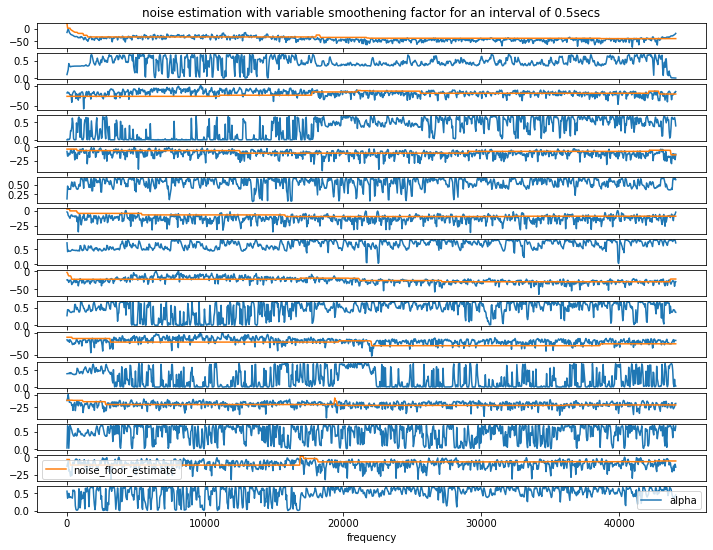

In [12]:
fig, ax = plt.subplots(niteration*2, 1, figsize=(12,9))
ax[0].set_title("noise estimation with variable smoothening factor for an interval of 0.5secs")
for i in range(niteration):
    ax[2*i].plot(f, 20*np.log10(abs(F_slide_fft[i])))
    ax[2*i].plot(f, noise_floor_est[i], label="noise_floor_estimate")
    ax[2*i + 1].plot(f, valpha[i], label="alpha")
ax[niteration*2-1].set_xlabel("frequency")
ax[niteration*2-1].legend()
ax[niteration*2-2].legend()